# Homework 3 - Emmanouil Chatzakis, 353068

In this homework, we are going to work with the transformer. There are three parts of this homework.

- In the first part, we are going to implement **positional encoding** and **self-attention**  and test them on a simple text dataset which contains around 100 sentences. We will use a small transformer in this task.

- In the second part, we will detect promoters from the DNA sequences. The main difference compared to the previous task is to tokenize the DNA sequence. Thus, our task here is to build the **tokenizer** to tokenize the DNA sequence. For the model, we will continue using the small transformer.

- In the third part, we will use a **foundation model** DNABERT to perform promoter detection. In this part, you do not need to train the transformer. Instead, you need to find and load the correct pre-trained model and then use it to get the embedding of the DNA sequence. Then, you will build a simple classifier to perform promoter detection based on the DNA embedding.



## 0. Initialization

Import the packages you are going to use here.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import random
import csv
import numpy as np
from torchmetrics.classification import BinaryF1Score

import ipywidgets as widgets
from types import SimpleNamespace
from utils import data, evaluation, models, visualization, text_exercise
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

import math

Set the hyperparameters.

In [2]:
# Set seeds
seed = 128
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Positional Encoding and Self-Attention (7 pts)

### 1.1. Sinusoidal Positional Encoding (1 pt)

In this section, you are going to implement the sinusoidal positional encoding. The formula is as the following:

<div>
<img src="./imgs/positional embedding.png" width="400"/>
</div>

where $t$ is the desired position in the input and $\mathsf{\omega}_k$ follows:

<div>
<img src="./imgs/omega.png" width="200"/>
</div>

To see the details of sinusoidal positional encoding, you can check this [link](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/).

In [3]:
class PositionalEmbedding(nn.Module):
    def __init__(self, max_position_embeddings, hidden_size, device):
        super().__init__()

        """
        max_position_embeddings: maximum length of the input - related to t in the previous formula
        hidden_size: encoding dimension - d in the previous formula
        """

        # ToDo: implement positional embedding
        # Hint: follow the previous formula
        pe = torch.zeros(max_position_embeddings, hidden_size).to(device)
        for pos in range(max_position_embeddings):
            for k in range(0, hidden_size, 2):
                pe[pos, k] = math.sin(pos / (10000 ** ((2 * k) / hidden_size)))
                pe[pos, k + 1] = math.cos(pos / (10000 ** ((2 * (k + 1)) / hidden_size)))
        
        self.positional_embedding = pe
        
        # Note: There are many implementations online, but in this version we implemented the one depicted in the formula
        # Different implementations might lead to different results, so small differences in the final results
        # should be expected based on the implementation
        # For example, the implementation with the -log, achieved 20% accuracy on section 2.2.

    def forward(self, x):
        return self.positional_embedding

    def embedding(self):
        return self.positional_embedding

Here, you can visualize your positional encoding. If you implement everything correctly, you can get a figure that is similar to Figure 2 in this [link](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/).

In [4]:
(
    visualize_embedding,
    dimension_selector,
    max_len_selector,
) = visualization.display_positional_encoding(PositionalEmbedding)
ui = widgets.HBox([max_len_selector, dimension_selector])
out = widgets.interactive_output(
    visualize_embedding, {"max_len": max_len_selector, "dimension": dimension_selector}
)
display(ui, out)

Output()

### 1.2. Self-Attention Mechanism (5 pts)

In this section, you are going to implement the self-attention mechanism. Please check the section 'Self-Attention in Detail' in this [link](https://jalammar.github.io/illustrated-transformer/) for the details of self-attention mechanism. (We encourage you to carefully go through the link since it is a very good tutorial for transformer.)

The specific steps will be provided in the comments of the following code. (The steps are only for reference. You do need to follow the steps if you have a better way to implement it.)

In [5]:
class BertSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        if config.hidden_size % config.num_attention_heads != 0:
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (config.hidden_size, config.num_attention_heads)
            )
        self.output_attentions = config.output_attentions
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        # ToDo: initialize K, Q, V (They are the weight matrices that the input embedding will be multiplied with)
        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        # ToDo: add a dropout layer
        # Hint: using config.attention_probs_dropout_prob as the dropout probability
        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (
            self.num_attention_heads,
            self.attention_head_size,
        )
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
    ):
        # The parameter encoder_hidden_states and encoder_attention_mask is for cross-attention.
        # We do not use them in this homework.

        # ToDo: get the key, query, and value from the hidden_states
        mixed_key_layer = self.key(hidden_states)
        mixed_query_layer = self.query(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        # ToDo: transpose K, Q, V to get the score
        # Hint: using self.transpose_for_scores
        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        # ToDo: Get the raw attention score
        # Hint: Lecture 05 transformers - Slide 23 - the part within the softmax
        attention_scores = torch.matmul(
            query_layer, key_layer.transpose(-1, -2)  # Transpose to be able to multiply
        ) / math.sqrt(self.attention_head_size)

        # You do not need to change this part.
        # Explanation of attention_mask: https://lukesalamone.github.io/posts/what-are-attention-masks/
        if attention_mask is not None:
            attention_scores = attention_scores + attention_mask

        # ToDo: Normalize the attention scores to probabilities.
        # Hint:
        # 1. Lecture 05 transformers - Slide 23 - using softmax to get the probability
        # 2. Use self.dropout to do the dropout
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout(attention_probs)

        # You do not need to change this part.
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        # ToDo: Multiply each value by the score
        # Hint:
        # 1. Lecture 05 transformers - Slide 23 - getting the final result
        # 2. Permuting the result to the correct shape. If you do not know what should be the correct shape, you can print the shape of the tensors.
        context_layer = torch.matmul(
            attention_probs, value_layer
        )  # res * V on slide 23

        # Up to this point we have claculated the context_layer
        # Now we apply some operations to get the output in a correct shape

        # Uncomment the following line if you want to see the shape of the context_layer.
        # print(f"Shape of context (Before perm): {context_layer.shape}")

        # Rearrange the dimensions of context_layer by permuting the dims
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()

        # Uncomment the following line if you want to see the shape of the context_layer after the permutation.
        # print(f"Shape of context (After perm):  {context_layer.shape}")

        # Calculate the shape that the context_layer should be
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)

        # Final Reshape for context_layer
        context_layer = context_layer.view(new_context_layer_shape)

        # Uncomment the following line if you want to see the shape of the context_layer after the reshape (final).
        # print(f"Shape of context (After view):  {context_layer.shape}")

        # Final shape: (batch_size, seq_len, hidden_size)
        
        # Get the output
        outputs = (
            (context_layer, attention_probs)
            if self.output_attentions
            else (context_layer,)
        )

        return outputs

Let's test your implementation using simple text data! First, let's load the data.

We use a small dataset in this homework for a shorter training time.

In [6]:
# ChatGPT generated text data about BERT
text = text_exercise.get()
sentences_df, vocab = data.to_sentence_df(text)

After loading the data, you can train your model. Here we train our model using masked token prediction.

Hint: The final model accuracy should be higher than 0.9.

In [7]:
text_max_len = 11

text_config = SimpleNamespace(
    vocab_size=len(vocab),
    hidden_size=60,
    max_position_embeddings=text_max_len,
    type_vocab_size=1,
    layer_norm_eps=1e-12,
    hidden_dropout_prob=0.0,
    attention_probs_dropout_prob=0.0,
    num_attention_heads=1,
    hidden_act="gelu",
    intermediate_size=160,
    num_hidden_layers=1,
    is_decoder=False,
    output_attentions=True,
    output_hidden_states=False,
    pruned_heads={},
    initializer_range=0.02,
    device="cpu",
)

tokenizer = data.TextTokenizer(vocab)
(
    input_ids,
    segment_ids,
    masked_lm_labels,
    labels_idx,
    labels,
    attention_masks,
) = data.generate_masked_data(
    sentences_df, tokenizer, k=1, max_len=text_max_len, noise_rate=0.4
)

model = models.BertForMaskedLM(
    config=text_config,
    positional_embedding=PositionalEmbedding,
    attention=BertSelfAttention,
)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
print(
    f"Number of trainable model parameters: {models.number_of_model_parameters(model)}"
)

for epoch in range(200):
    optimizer.zero_grad()
    loss, outputs, attentions = model(
        input_ids=input_ids,
        token_type_ids=segment_ids,
        masked_lm_labels=masked_lm_labels,
        attention_mask=attention_masks,
    )
    if (epoch + 1) % 20 == 0:
        print("Epoch:", "%04d" % (epoch + 1), "loss =", "{:.6f}".format(loss))
    loss.backward()
    optimizer.step()

print(
    f"Final model accuracy: {evaluation.masked_label_accuracy(labels, labels_idx, outputs.data)}"
)

Number of trainable model parameters: 64910
Epoch: 0020 loss = 4.345042
Epoch: 0040 loss = 3.727527
Epoch: 0060 loss = 3.115082
Epoch: 0080 loss = 2.573718
Epoch: 0100 loss = 2.118935
Epoch: 0120 loss = 1.726218
Epoch: 0140 loss = 1.373642
Epoch: 0160 loss = 1.028634
Epoch: 0180 loss = 0.821390
Epoch: 0200 loss = 0.521188
Final model accuracy: 0.9844961240310077


### 1.3. Visualize Attention (1 pt)

Here, you can visualize the self-attention. 

Question: Can you interpret the visualization of the self-attention?

**Write down you answer here (1 pt):**

Self-Attention is a transformer mechanism that allows the model to correlate the words of an input sentence, capturing the dependencies of different terms based on the semantics encapsulated in the input.

The graph generated below presents the attention weights of the model we used above. The goal of the visualization is to present how attention correlates and captures term dependencies of input given to the transformer model. 
The value of attention is presented as color density, meaning that more dense colors represent higher scores and thus higher level of dependency between the corresponding terms. 

Specifically, in this graph we see the results for single-head attention (head=1). Single-head attention calculates the scores of each word with respect to all other words of the input in a single pass, by computing the dot products of query Q, key K and value V for each word.

For example, for the input sample of "Tranformers do many tasks", the pair "many" and "tasks" shares a dense color in the visualization, because the model "understands" that the token "many" refers to the token "tasks".

From the resulting graph, we see that in many cases, our model manages to correctly capture the dependencies across different terms, regardless of the position of those terms in the input text.


In [8]:
visualize_attention, sample_id_selector = visualization.display_attantion(
    attentions=attentions, input_ids=input_ids, tokenizer=tokenizer
)
widgets.interactive(visualize_attention, sample_id=sample_id_selector)

interactive(children=(Dropdown(description='Sample:', options=(5, 8, 11, 13, 18, 24, 26, 29, 31, 35, 37, 38, 6…

### 1.4. Train on small Wikitext Dataset

Here, you can **optionally** test your model on the smallest wikitext dataset. You should get an test accuracy around 0.4 after training 50 epochs.

This part is only for you to test your code. You can choose to run it or not. It takes around 1 hour to train the model for 50 epochs on the smallest wikitext dataset with Google Colab.

In [9]:
# This part required a lot of time, thus it is commented out.
# text_exercise.train_wikitext(
#    device, positional_embedding=PositionalEmbedding, attention=BertSelfAttention
# )

## 2. Promoter detection (7 pts)

In this section, we detect promoter in DNA sequence.

A promoter is a region of DNA upstream of a gene where relevant proteins (such as RNA polymerase and transcription factors) bind to initiate transcription of that gene. Promoter detection is to identify if there are promoter regions in the given DNA sequence. We have covered this in the lecture. (If you are interested in the promoter, you can check this [link](https://www.genome.gov/genetics-glossary/Promoter) for more details.)

Here, we use a transformer and a classifier. The transformer first embeds the DNA sequences into features, and then the classifier detects the promoter based on the features.

The main difference between text and DNA sequence is how to tokenize the sequence. Thus, you need to implement a tokenizer for the DNA sequence.

### 2.1. DNA Tokenizer (1 pts)

Here, you will implement the DNA tokenizer the same as in DNABERT. Please check this [paper](https://academic.oup.com/bioinformatics/article/37/15/2112/6128680) for implementation details. Also, you need to check the data type and shape for both input and output.

In [10]:
class DNATokenizer(data.Tokenizer):
    def __init__(self, k, vocab, unknown="[UNK]"):
        super().__init__(vocab, unknown)

        # self.k is the k of k-mers
        self.k = k

    def _parse_text(self, text):
        
        assert isinstance(text, str), "Input text should be a string."
        assert len(text) >= self.k, "Input text should be longer than k."

        # Generate the k-mer tokens as in DNABERT
        tokens = []
        for i in range(len(text) - self.k + 1):
            token = text[i : i + self.k]
            if token in self.token2idx.keys():
                tokens.append(token)
            else:
                tokens.append(self.unknown)

        output = tokens
        return output

### 2.2. Test BERT on DNA Sequence

In this section, you will train BERT on DNA sequence to learn the embedding of DNA sequence. The code is provided below and you do not need to write anything.

Hint: the final evaluation accuracy should be higher than 0.2.

In [11]:
kmer = 3
mask_length = kmer
VOCAB_3MER = [
    "[PAD]",
    "[UNK]",
    "[CLS]",
    "[SEP]",
    "[MASK]",
    "AAA",
    "AAT",
    "AAC",
    "AAG",
    "ATA",
    "ATT",
    "ATC",
    "ATG",
    "ACA",
    "ACT",
    "ACC",
    "ACG",
    "AGA",
    "AGT",
    "AGC",
    "AGG",
    "TAA",
    "TAT",
    "TAC",
    "TAG",
    "TTA",
    "TTT",
    "TTC",
    "TTG",
    "TCA",
    "TCT",
    "TCC",
    "TCG",
    "TGA",
    "TGT",
    "TGC",
    "TGG",
    "CAA",
    "CAT",
    "CAC",
    "CAG",
    "CTA",
    "CTT",
    "CTC",
    "CTG",
    "CCA",
    "CCT",
    "CCC",
    "CCG",
    "CGA",
    "CGT",
    "CGC",
    "CGG",
    "GAA",
    "GAT",
    "GAC",
    "GAG",
    "GTA",
    "GTT",
    "GTC",
    "GTG",
    "GCA",
    "GCT",
    "GCC",
    "GCG",
    "GGA",
    "GGT",
    "GGC",
    "GGG",
]

raw_training_data = data.load_csv("./data/train.csv")
raw_test_data = data.load_csv("./data/test.csv")

dna_max_len = 298
batch_size = 128
max_dna_mask = 100
dataset_size = 1000
num_layers = 3
num_heads = 6
dna_config = SimpleNamespace(
    vocab_size=len(VOCAB_3MER),
    hidden_size=60,
    max_position_embeddings=dna_max_len,
    type_vocab_size=1,
    layer_norm_eps=1e-12,
    hidden_dropout_prob=0.0,
    attention_probs_dropout_prob=0.0,
    num_attention_heads=num_heads,
    hidden_act="gelu",
    intermediate_size=160,
    num_hidden_layers=num_layers,
    is_decoder=False,
    output_attentions=True,
    output_hidden_states=True,
    pruned_heads={},
    initializer_range=0.02,
    device=device,
)

tokenizer = DNATokenizer(k=kmer, vocab=VOCAB_3MER)

(
    input_ids,
    segment_ids,
    masked_lm_labels,
    labels_idx,
    labels,
    attention_masks,
) = data.generate_masked_data(
    raw_training_data,
    tokenizer,
    max_len=dna_max_len,
    max_mask=max_dna_mask,
    k=mask_length,
    mask_rate=0.05,
    max_size=dataset_size,
)


(
    test_input_ids,
    test_segment_ids,
    test_masked_lm_labels,
    test_labels_idx,
    test_labels,
    test_attention_masks,
) = data.generate_masked_data(
    raw_test_data,
    tokenizer,
    max_len=dna_max_len,
    max_mask=max_dna_mask,
    k=mask_length,
    mask_rate=0.05,
    max_size=dataset_size,
)

model = models.BertForMaskedLM(
    config=dna_config,
    positional_embedding=PositionalEmbedding,
    attention=BertSelfAttention,
).to(device)

optimizer = optim.AdamW(model.parameters(), lr=0.002)
print(
    f"Number of trainable model parameters: {models.number_of_model_parameters(model)}"
)

train_dataset = TensorDataset(
    input_ids, segment_ids, masked_lm_labels, labels_idx, labels, attention_masks
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(
    test_input_ids,
    test_segment_ids,
    test_masked_lm_labels,
    test_labels_idx,
    test_labels,
    test_attention_masks,
)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(50):
    total_train_loss = 0
    model.train()
    for (
        batch_input_ids,
        batch_segment_ids,
        batch_masked_lm_labels,
        _,
        _,
        batch_attention_mask,
    ) in train_loader:
        optimizer.zero_grad()
        loss, outputs, hidden_states, _ = model(
            input_ids=batch_input_ids.to(device),
            token_type_ids=batch_segment_ids.to(device),
            masked_lm_labels=batch_masked_lm_labels.to(device),
            attention_mask=batch_attention_mask.to(device),
        )
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    if (epoch + 1) % 10 == 0:
        model.eval()
        total_eval_loss = 0
        for (
            batch_input_ids,
            batch_segment_ids,
            batch_masked_lm_labels,
            _,
            _,
            batch_attention_mask,
        ) in test_loader:
            with torch.no_grad():
                loss, outputs, hidden_states, _ = model(
                    input_ids=batch_input_ids.to(device),
                    token_type_ids=batch_segment_ids.to(device),
                    masked_lm_labels=batch_masked_lm_labels.to(device),
                    attention_mask=batch_attention_mask.to(device),
                )
                if batch_attention_mask.sum() - torch.numel(batch_attention_mask) > 0:
                    print("found patting", batch_attention_mask.sum())
                total_eval_loss += loss.item()
        avg_eval_loss = total_eval_loss / len(test_loader)
        print(
            "Epoch:",
            "%04d" % (epoch + 1),
            "train cost =",
            "{:.6f}".format(avg_train_loss),
            "eval cost =",
            "{:.6f}".format(avg_eval_loss),
        )

average_train_acc, _ = evaluation.model_masked_label_accuracy(
    model, train_loader, device
)

average_test_acc, last_test_attention = evaluation.model_masked_label_accuracy(
    model, test_loader, device
)

print(
    "Train Acc =",
    "{:.6f}".format(average_train_acc),
    "Eval Acc =",
    "{:.6f}".format(average_test_acc),
)

Number of trainable model parameters: 118869
Epoch: 0010 train cost = 4.070847 eval cost = 4.111247
Epoch: 0020 train cost = 3.964024 eval cost = 4.030648
Epoch: 0030 train cost = 3.685124 eval cost = 3.785486
Epoch: 0040 train cost = 3.129690 eval cost = 3.309906
Epoch: 0050 train cost = 2.662739 eval cost = 2.935166
Train Acc = 0.193638 Eval Acc = 0.127012


### 2.3. Visualize the Attentions (1 pt)

Here, you can visualize the self-attention. 

Question: compare the visualization to Section 1.3, what can you find here? How do you explain it?

**Write down you answer here (1 pt):**

The visualization of attention below follows the same rationale as the one in Section 1: It presents how the model captures the dependencies or semantic correlation of the terms of the input, representing the attention scores as color density.

Here, instead of presenting the attention values between words of an input sentence, the graph presents the correlation of DNA k-mer sequences, as captured from the transformer. In addition, this graph presents the attention for a transformer model that uses multiple attention heads (multi-head attention) and many layers. 

Multi-head attention differs from single-head (Section 1), since it allows the different heads to focus on different aspects of the input sequence and capture various patterns and relationships simultaneously, at the expense of more training parameters, because every attention layer has its own trainable parameter set. It is important to notice that the final attention score is calculated using an aggregation module of the different attention layes, for example mean or max pooling.

The results of multi-head attention are depicted in the graph below, for any layer of the model. Through the graph, we can see for any sample and any layer, the correlations captured by any of the available heads of attention, allowing us to better interpret the connections between the k-mer sequences of the DNA. 

In [12]:
(
    visualize_attention,
    sample_id_selector,
    layer_selector,
    head_selector,
) = visualization.display_multi_attantion(
    attentions=last_test_attention,
    tokenizer=tokenizer,
    input_ids=input_ids,
    layers=range(1, num_layers + 1),
    heads=range(1, num_heads + 1),
)
ui = widgets.HBox([sample_id_selector, layer_selector, head_selector])
out = widgets.interactive_output(
    visualize_attention,
    {"sample_id": sample_id_selector, "layer": layer_selector, "head": head_selector},
)
display(ui, out)

Output()

### 2.4. Use your pretrained model for promoter detection (5 pts)

You already have the embeddings for the DNA sequence. Now, you are going to build a classifier based on the DNA embeddings. The classifier is to perform promoter detection. Specifically, the DNA sequence will be classified into *'contains promoter'* or *'does not contain promoter'*.

Hint: 
- We now want to annotate data (get the label for each sample), not predict masked data anymore!
- You can reuse some parts of the code in the previous sections, e.g. dataloader and training pipeline in Section 2.2.
- If you implement the previous section correctly (the Eval Acc > 0.2 in Section 2.2), you already have an pre-trained object named 'model' of class models.BertForMaskedLM. You can directly use it.
- The evaluation accuracy of this task should be around 0.6.

In [13]:
# ToDo: Define the classifier
# Hint: We need only a binary classifier.
class BinaryClassifier(nn.Module):
    """A binary classifer of configurable layer sizes"""

    def __init__(self, input_size, hidden_sizes, output_size):
        super().__init__()

        # Stack the linear layers
        self.linear = nn.Sequential()
        curr_size = input_size
        for hsize in hidden_sizes:
            self.linear.append(nn.Linear(curr_size, hsize))
            curr_size = hsize

        self.linear.append(nn.Linear(curr_size, output_size))

    def forward(self, x):
        """Forward pass of the classifier

        Args:
            x (tensor): input features

        Returns:
            tensor: A tensor of shape (batch_size, output_size)
        """
        return self.linear(x)

In [14]:
# ToDo: Freeze BERT parameters
# Hint:
# 1. BERT is the 'model' you have trained in Section 2.2.
# 2. Check Exercise 1 to see how to freeze a model (set requires_grad to False)
BERTModel = model
BERTModel.requires_grad = False

In [15]:
# ToDo: Train your classifier
# Hint:
# 1. Write the training pipeline (dataloader, optimizer, training loop ...)
# 2. You can reuse the code from Section 2.2.

# Reload the data the same way as Section 2.2.
# Here, we prepare the data including the classification labels for promoter detection.

kmer = 3
mask_length = kmer
VOCAB_3MER = [
    "[PAD]",
    "[UNK]",
    "[CLS]",
    "[SEP]",
    "[MASK]",
    "AAA",
    "AAT",
    "AAC",
    "AAG",
    "ATA",
    "ATT",
    "ATC",
    "ATG",
    "ACA",
    "ACT",
    "ACC",
    "ACG",
    "AGA",
    "AGT",
    "AGC",
    "AGG",
    "TAA",
    "TAT",
    "TAC",
    "TAG",
    "TTA",
    "TTT",
    "TTC",
    "TTG",
    "TCA",
    "TCT",
    "TCC",
    "TCG",
    "TGA",
    "TGT",
    "TGC",
    "TGG",
    "CAA",
    "CAT",
    "CAC",
    "CAG",
    "CTA",
    "CTT",
    "CTC",
    "CTG",
    "CCA",
    "CCT",
    "CCC",
    "CCG",
    "CGA",
    "CGT",
    "CGC",
    "CGG",
    "GAA",
    "GAT",
    "GAC",
    "GAG",
    "GTA",
    "GTT",
    "GTC",
    "GTG",
    "GCA",
    "GCT",
    "GCC",
    "GCG",
    "GGA",
    "GGT",
    "GGC",
    "GGG",
]

raw_training_data = data.load_csv("./data/train.csv")
raw_test_data = data.load_csv("./data/test.csv")

dna_max_len = 298
batch_size = 128
max_dna_mask = 100
dataset_size = 1000
num_layers = 3
num_heads = 6
dna_config = SimpleNamespace(
    vocab_size=len(VOCAB_3MER),
    hidden_size=60,
    max_position_embeddings=dna_max_len,
    type_vocab_size=1,
    layer_norm_eps=1e-12,
    hidden_dropout_prob=0.0,
    attention_probs_dropout_prob=0.0,
    num_attention_heads=num_heads,
    hidden_act="gelu",
    intermediate_size=160,
    num_hidden_layers=num_layers,
    is_decoder=False,
    output_attentions=True,
    output_hidden_states=True,
    pruned_heads={},
    initializer_range=0.02,
    device=device,
)

tokenizer = DNATokenizer(k=kmer, vocab=VOCAB_3MER)

(
    input_ids,
    segment_ids,
    masked_lm_labels,
    labels_idx,
    labels,
    attention_masks,
) = data.generate_masked_data(
    raw_training_data,
    tokenizer,
    max_len=dna_max_len,
    max_mask=max_dna_mask,
    k=mask_length,
    mask_rate=0.05,
    max_size=dataset_size,
)


(
    test_input_ids,
    test_segment_ids,
    test_masked_lm_labels,
    test_labels_idx,
    test_labels,
    test_attention_masks,
) = data.generate_masked_data(
    raw_test_data,
    tokenizer,
    max_len=dna_max_len,
    max_mask=max_dna_mask,
    k=mask_length,
    mask_rate=0.05,
    max_size=dataset_size,
)

# Extract the labels from the raw data
train_promoter_labels = torch.Tensor(
    raw_training_data["label"][0:dataset_size].to_numpy()
).unsqueeze(1)
test_promoter_labels = torch.Tensor(
    raw_test_data["label"][0:dataset_size].to_numpy()
).unsqueeze(1)

train_dataset = TensorDataset(
    input_ids,
    segment_ids,
    masked_lm_labels,
    labels_idx,
    labels,
    attention_masks,
    train_promoter_labels,
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(
    test_input_ids,
    test_segment_ids,
    test_masked_lm_labels,
    test_labels_idx,
    test_labels,
    test_attention_masks,
    test_promoter_labels,
)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Size of training dataset: {len(train_dataset)}")
print(f"Size of test dataset: {len(test_dataset)}")

Size of training dataset: 1000
Size of test dataset: 1000


In [16]:
# Training Loop
IN_FEATURES = 60
EPOCHS = 50

# We define a 3-layer classifier. Feel free to change the number of hidden layers. 
bc = BinaryClassifier(IN_FEATURES, [60], 2)

# We use CrossEntropyLoss as the loss function.
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(bc.parameters(), lr=0.0002)

final_acc = 0
for epoch in tqdm(range(EPOCHS)):
    total_train_loss = 0
    train_predicted_labels = []
    train_true_labels = []

    # Train
    bc.train()
    for (
        batch_input_ids,
        batch_segment_ids,
        batch_masked_lm_labels,
        batch_labels_idx,
        batch_labels,
        batch_attention_mask,
        batch_promoter_labels,
    ) in train_loader:
        optimizer.zero_grad()

        # Use BERT to get the hidden states (embedding)
        _, _, hidden_state, _ = BERTModel(
            input_ids=batch_input_ids.to(device),
            token_type_ids=batch_segment_ids.to(device),
            masked_lm_labels=batch_masked_lm_labels.to(device),
            attention_mask=batch_attention_mask.to(device),
        )

        # Uncomment the following lines if you want to see the shape of the hidden states.
        # print(f"Shape of hidden_state: {hidden_state[-1].shape}")

        # Extract the embedding and use if as the classifier input. Use mean pooling to get the embedding.
        X = torch.mean(hidden_state[0], dim=1)
        
        # Uncomment the following lines if you want to see the shape of the classifier input.
        # print(f"Shape of mean_pool: {X.shape}")

        # Get the batch labels and convert them to longs (for cross entropy loss)
        y = batch_promoter_labels.squeeze().long()
        
        # Uncomment the following lines if you want to see the shape of the labels.
        # print(f"Shape of labels: {y.shape}")
        
        # Get the classification logits
        logits = bc(X)
        
        # Uncomment the following lines if you want to see the shape of the logits.
        # print(f"Shape of logits: {logits.shape}")

        # Perform backward pass and update the weights
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        # Keep loss statistics
        total_train_loss += loss.item()
        
        # Get the predicted class
        pred_class = torch.argmax(logits, dim=1)
        
        # Uncomment the following lines if you want to see the shape of the predicted class.
        # print(f"Shape of pred_class: {pred_class.shape}")

        # Keep the prediction results
        train_predicted_labels += list(pred_class.cpu().numpy())
        train_true_labels += list(y.cpu().numpy())

    # Evaluate the performance periodically (use the test set)
    if (epoch + 1) % 5 == 0 or epoch == EPOCHS - 1:
        bc.eval()

        # Same operation as the training loop, but without the backward pass

        test_predicted_labels = []
        test_true_labels = []

        total_eval_loss = 0
        for (
            batch_input_ids,
            batch_segment_ids,
            batch_masked_lm_labels,
            _,
            _,
            batch_attention_mask,
            batch_promoter_labels,
        ) in test_loader:
            with torch.no_grad():
                _, _, hidden_states, _ = model(
                    input_ids=batch_input_ids.to(device),
                    token_type_ids=batch_segment_ids.to(device),
                    masked_lm_labels=batch_masked_lm_labels.to(device),
                    attention_mask=batch_attention_mask.to(device),
                )

                X = torch.mean(hidden_states[0], dim=1)
                y = batch_promoter_labels.squeeze().long()
                logits = bc(X)

                loss = criterion(logits, y)
                total_eval_loss += loss.item()

                pred_class = torch.argmax(logits, dim=1)
                test_predicted_labels += list(pred_class.cpu().numpy())
                test_true_labels += list(y.cpu().numpy())

        # Calculate loss
        avg_eval_loss = total_eval_loss / len(test_loader)
        avg_train_loss = total_train_loss / len(train_loader)

        # Calculate accuracy
        test_accuracy = np.mean(
            np.array(test_predicted_labels) == np.array(test_true_labels)
        )

        train_accuracy = np.mean(
            np.array(train_predicted_labels) == np.array(train_true_labels)
        )

        # Print the results
        print(
            f"E{epoch+1} Train Loss: {avg_train_loss}, Eval Loss: {avg_eval_loss}, Train Acc: {train_accuracy}, Eval Acc: {test_accuracy}"
        )

        # Since we use the testing set, the accuracy of the last epoch is the final overall accuracy of our classifier.
        if epoch == EPOCHS - 1:
            final_acc = test_accuracy

print(f"\n==== Final test accuracy: {final_acc*100.0}% ====")

 10%|█         | 5/50 [00:25<04:14,  5.66s/it]

E5 Train Loss: 0.6866684257984161, Eval Loss: 0.6874917671084404, Train Acc: 0.514, Eval Acc: 0.535


 20%|██        | 10/50 [00:49<03:43,  5.59s/it]

E10 Train Loss: 0.6805088669061661, Eval Loss: 0.6836500987410545, Train Acc: 0.606, Eval Acc: 0.567


 30%|███       | 15/50 [01:14<03:14,  5.55s/it]

E15 Train Loss: 0.6748155504465103, Eval Loss: 0.6793255507946014, Train Acc: 0.548, Eval Acc: 0.561


 40%|████      | 20/50 [01:39<02:46,  5.56s/it]

E20 Train Loss: 0.6683152094483376, Eval Loss: 0.6758101806044579, Train Acc: 0.59, Eval Acc: 0.57


 50%|█████     | 25/50 [02:03<02:18,  5.53s/it]

E25 Train Loss: 0.6626682505011559, Eval Loss: 0.6733591333031654, Train Acc: 0.614, Eval Acc: 0.586


 60%|██████    | 30/50 [02:28<01:51,  5.57s/it]

E30 Train Loss: 0.6578923985362053, Eval Loss: 0.6716553121805191, Train Acc: 0.617, Eval Acc: 0.593


 70%|███████   | 35/50 [02:53<01:24,  5.61s/it]

E35 Train Loss: 0.6527504771947861, Eval Loss: 0.6704450100660324, Train Acc: 0.64, Eval Acc: 0.594


 80%|████████  | 40/50 [03:17<00:55,  5.54s/it]

E40 Train Loss: 0.6482790187001228, Eval Loss: 0.6690897271037102, Train Acc: 0.628, Eval Acc: 0.587


 90%|█████████ | 45/50 [03:42<00:27,  5.54s/it]

E45 Train Loss: 0.6444099694490433, Eval Loss: 0.6687267646193504, Train Acc: 0.634, Eval Acc: 0.586


100%|██████████| 50/50 [04:07<00:00,  4.94s/it]

E50 Train Loss: 0.6427288800477982, Eval Loss: 0.6697930842638016, Train Acc: 0.623, Eval Acc: 0.586

==== Final test accuracy: 58.599999999999994% ====


### 2.5. Additional question (1 pt)

Now we change mask_length = 1 (already changed, you do not need to implement anything).
Let's run the code below and check the accuracy.

Question: What is the final masked token prediction accuracy? How do you explain this?

**Write down you answer here (1 pt):**

The initial training of the model used mask_length=kmer and achieved an accuracy of approximately 0.2. In this section we retrain the model for mask_length=1, getting a test accuracy of approximately 0.52, which is an important improvement of the previous result.

Using mask_length=1 means that the model only considers the previous token (dna k-mer) during learning and evaluation. This allows the model to focus on the local context of each token, and discard connections from distant positions in the input. This is an implicit regularization method that manages to give better results regarding our DNA data.


In [17]:
kmer = 3
mask_length = 1

dna_max_len = 298
batch_size = 128
max_dna_mask = 100
dataset_size = 1000
num_layers = 3
num_heads = 6
dna_config = SimpleNamespace(
    vocab_size=len(VOCAB_3MER),
    hidden_size=60,
    max_position_embeddings=dna_max_len,
    type_vocab_size=1,
    layer_norm_eps=1e-12,
    hidden_dropout_prob=0.0,
    attention_probs_dropout_prob=0.0,
    num_attention_heads=num_heads,
    hidden_act="gelu",
    intermediate_size=160,
    num_hidden_layers=num_layers,
    is_decoder=False,
    output_attentions=True,
    output_hidden_states=True,
    pruned_heads={},
    initializer_range=0.02,
    device=device,
)

tokenizer = DNATokenizer(k=3, vocab=VOCAB_3MER)
(
    input_ids,
    segment_ids,
    masked_lm_labels,
    labels_idx,
    labels,
    attention_masks,
) = data.generate_masked_data(
    raw_training_data,
    tokenizer,
    max_len=dna_max_len,
    max_mask=max_dna_mask,
    k=mask_length,
    mask_rate=0.05,
    max_size=dataset_size,
)
(
    test_input_ids,
    test_segment_ids,
    test_masked_lm_labels,
    test_labels_idx,
    test_labels,
    test_attention_masks,
) = data.generate_masked_data(
    raw_test_data,
    tokenizer,
    max_len=dna_max_len,
    max_mask=max_dna_mask,
    k=mask_length,
    mask_rate=0.05,
    max_size=dataset_size,
)

model = models.BertForMaskedLM(
    config=dna_config,
    positional_embedding=PositionalEmbedding,
    attention=BertSelfAttention,
).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.002)
print(
    f"Number of trainable model parameters: {models.number_of_model_parameters(model)}"
)

train_dataset = TensorDataset(
    input_ids, segment_ids, masked_lm_labels, labels_idx, labels, attention_masks
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(
    test_input_ids,
    test_segment_ids,
    test_masked_lm_labels,
    test_labels_idx,
    test_labels,
    test_attention_masks,
)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(50):
    total_train_loss = 0
    model.train()
    for (
        batch_input_ids,
        batch_segment_ids,
        batch_masked_lm_labels,
        _,
        _,
        batch_attention_mask,
    ) in train_loader:
        optimizer.zero_grad()
        loss, outputs, hidden_states, _ = model(
            input_ids=batch_input_ids.to(device),
            token_type_ids=batch_segment_ids.to(device),
            masked_lm_labels=batch_masked_lm_labels.to(device),
            attention_mask=batch_attention_mask.to(device),
        )
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)

    if (epoch + 1) % 10 == 0:
        model.eval()
        total_eval_loss = 0
        for (
            batch_input_ids,
            batch_segment_ids,
            batch_masked_lm_labels,
            _,
            _,
            batch_attention_mask,
        ) in test_loader:
            with torch.no_grad():
                loss, outputs, hidden_states, _ = model(
                    input_ids=batch_input_ids.to(device),
                    token_type_ids=batch_segment_ids.to(device),
                    masked_lm_labels=batch_masked_lm_labels.to(device),
                    attention_mask=batch_attention_mask.to(device),
                )
                if batch_attention_mask.sum() - torch.numel(batch_attention_mask) > 0:
                    print("found patting", batch_attention_mask.sum())
                total_eval_loss += loss.item()
        avg_eval_loss = total_eval_loss / len(test_loader)
        print(
            "Epoch:",
            "%04d" % (epoch + 1),
            "train cost =",
            "{:.6f}".format(avg_train_loss),
            "eval cost =",
            "{:.6f}".format(avg_eval_loss),
        )

average_train_acc, _ = evaluation.model_masked_label_accuracy(
    model, train_loader, device
)
average_test_acc, last_test_attention = evaluation.model_masked_label_accuracy(
    model, test_loader, device
)
print(
    "Train Acc =",
    "{:.6f}".format(average_train_acc),
    "Eval Acc =",
    "{:.6f}".format(average_test_acc),
)

Number of trainable model parameters: 118869
Epoch: 0010 train cost = 4.056550 eval cost = 4.104567
Epoch: 0020 train cost = 3.741975 eval cost = 3.799120
Epoch: 0030 train cost = 2.707941 eval cost = 2.777367
Epoch: 0040 train cost = 1.772625 eval cost = 1.941891
Epoch: 0050 train cost = 1.213531 eval cost = 1.511941
Train Acc = 0.632678 Eval Acc = 0.528691


## 3. Using foundation model (5 pts)

### 3.1. Introduction

In this section, we aim to use a foundation model, DNABERT, to perform promoter detection.
A foundation model is a model pretrained on large datasets. Foundation models serve as the foundational building blocks upon which various applications can be constructed.

Here, we use DNABERT as the foundation model. We first apply it on DNA sequence to get the embedding. Then, we train a classifier on the embedding as in Section 2. Please follow this [link](https://github.com/Zhihan1996/DNABERT_2) to load the foundation model.

### 3.2. Implementation

**Consider this situation:** You get a dataset about promoter detection, and you build your model to perform the task as in Section 2. However, the performance is not good since the model is not strong enough. Suddenly, you think we can use a large pre-trained model to embed DNA sequences. Then, you search online and find the pre-trained model [DNABERT](https://github.com/Zhihan1996/DNABERT_2). Now, you want to perform promoter detection using the pre-trained DNABERT.

There is no coding framework in this section. Just make things work (get good test accuracy) using the pre-trained model!

Hint: 
- We encourage you to create a **new environment** following the instructions of Section 3 in this [link](https://github.com/Zhihan1996/DNABERT_2). (When you face the error "The model class you are passing has a config_class attribute that is not consistent with the config class you passed ...", creating a new environment can save you.)
- Section 4 in this [link](https://github.com/Zhihan1996/DNABERT_2) shows you how to load and use the pre-trained foundation model.

a. Load the dataset.

In [18]:
# ToDo: Load the train and test datasets from train.csv and test.csv
# Hint: check Section 2.2.
training_data = pd.read_csv("./data/train.csv")
testing_data = pd.read_csv("./data/test.csv")

print(f"Total size of training data: {len(training_data)}")
print(f"Total size of testing data: {len(testing_data)}")

Total size of training data: 47356
Total size of testing data: 5920


b. Get the embeddings of the DNA sequences using pretrained model.

Hint: 
- This step can take some time. Thus, you can start with a small sample size, and then increase it when you have made sure that everything works correctly.
- After getting the embeddings, you can save them so that you can directly load them next time without running the foundation model.

In [19]:
# Define some helper functions
def get_mean_embedding(dna_seq, model, tokenizer):
    """Mean-pool a DNA-bert embedding"""
    inputs = tokenizer(dna_seq, return_tensors="pt")["input_ids"]
    hidden_states = model(inputs)[0]
    embedding_mean = torch.mean(hidden_states[0], dim=0)
    return embedding_mean


def save_embeddings_csv(data, filename, model, tokenizer):
    """Generate a DNABERT embedding and save it to a csv file"""
    with open(filename, "w", newline="") as csv_file:
        csv_writer = csv.writer(csv_file)
        for i in tqdm(range(len(data)), desc=f"Saving embeddings to {filename}"):
            dna_seq = data["sequence"][i]
            csv_writer.writerow(
                get_mean_embedding(dna_seq, model, tokenizer).detach().numpy()
            )

In [20]:
# ToDo: Load the pretrained DNABERT model and use this to get the embeddings of the train and test DNA sequences.
# Hint: Check section Quick Start on https://github.com/Zhihan1996/DNABERT_2

# We use a smaller sample to keep training time short and memory usage low.
# In case you want to use all the data, set DATA_SAMPLES to -1.
DATA_SAMPLES = 5000
if DATA_SAMPLES != -1:
    sampled_training_data = training_data[:DATA_SAMPLES]
    sampled_testing_data = testing_data[:DATA_SAMPLES]
else:
    sampled_training_data = training_data
    sampled_testing_data = testing_data

# Initialize DNABERT tokenizer and model
dnaTokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
dnaBERT = AutoModel.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)

# Select the filename to save the embeddings
TRAIN_EMBEDDINGS_FILENAME = f"./train_embeddings.size{DATA_SAMPLES}.csv"
TEST_EMBEDDINGS_FILENAME = f"./test_embeddings.size{DATA_SAMPLES}.csv"

# Set USE_PRETRAINED to False if you want to generate the embeddings from scratch.
# The embeddings will be saved to a file locally (due to memory constraints).
USE_PRETRAINED = False
if USE_PRETRAINED == False:
    # Generate and save the embeddings (only for the first time)
    save_embeddings_csv(sampled_training_data, TRAIN_EMBEDDINGS_FILENAME, dnaBERT, dnaTokenizer)
    save_embeddings_csv(sampled_testing_data, TEST_EMBEDDINGS_FILENAME, dnaBERT, dnaTokenizer)

# Load the pre-generated DNABERT embeddings
train_embeddings = np.loadtxt(TRAIN_EMBEDDINGS_FILENAME, delimiter=",")
test_embeddings = np.loadtxt(TEST_EMBEDDINGS_FILENAME, delimiter=",")

# Sanity check
print(f"Train embeddings shape: {train_embeddings.shape}")
print(f"Test embeddings shape: {test_embeddings.shape}")

/Users/manoschatzakis/.cache/huggingface/modules/transformers_modules/zhihan1996/DNABERT-2-117M/1d020b803b871a976f5f3d5565f0eac8f2c7bb81/bert_layers.py:125: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of the model checkpoint at zhihan1996/DNABERT-2-117M were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expe

Train embeddings shape: (5000, 768)
Test embeddings shape: (5000, 768)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


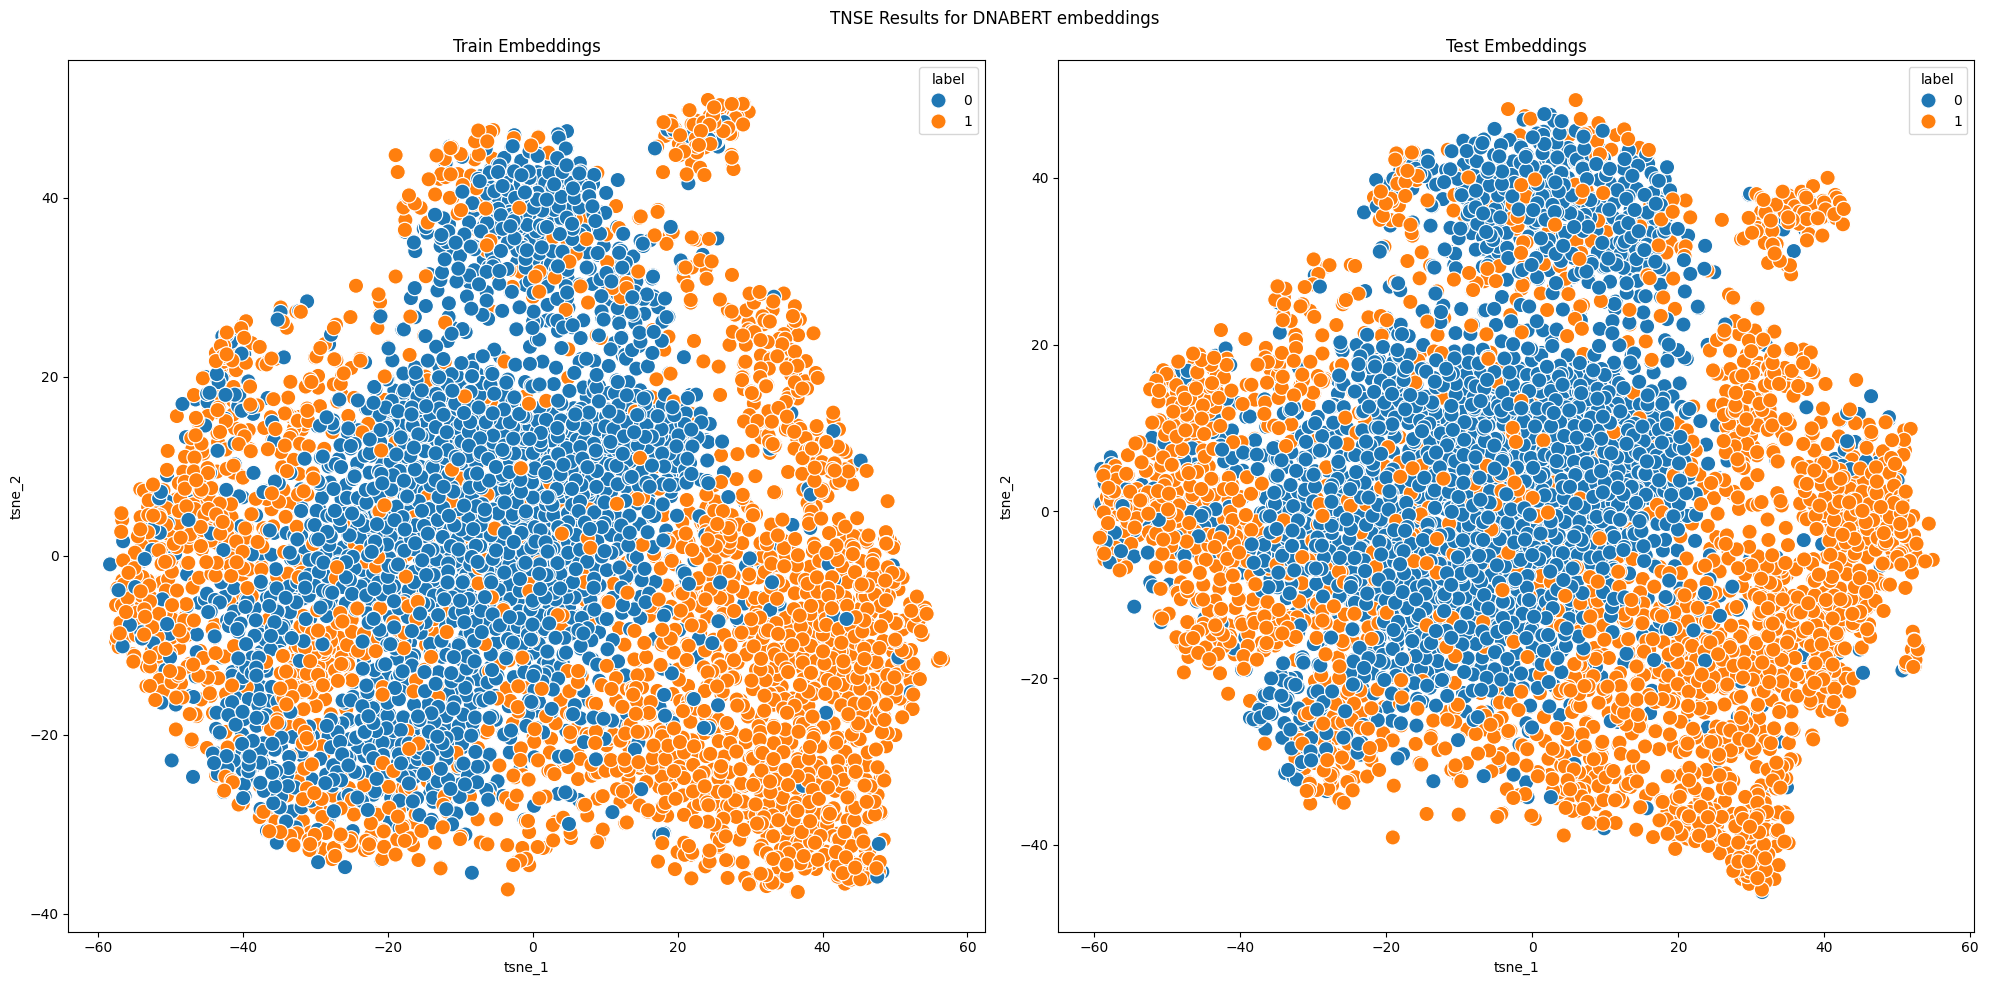

In [21]:
# ToDo: Using tsne or umap to visualize the embedding space.
# Hint: you can import other packages here for visualization.

# Apply TNSE to train embeddings
X_train = train_embeddings
tsne_train = TSNE(2).fit_transform(X_train)
tsne_train_df = pd.DataFrame(
    {
        "tsne_1": tsne_train[:, 0],
        "tsne_2": tsne_train[:, 1],
        "label": sampled_training_data["label"],
    }
)

# Apply TNSE to test embeddings
X_test = test_embeddings
tsne_test = TSNE(2).fit_transform(X_test)
tsne_test_df = pd.DataFrame(
    {
        "tsne_1": tsne_test[:, 0], 
        "tsne_2": tsne_test[:, 1], 
        "label": sampled_testing_data["label"]}
)

# Create the plots
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.scatterplot(x="tsne_1", y="tsne_2", hue="label", data=tsne_train_df, ax=ax[0], s=120)
sns.scatterplot(x="tsne_1", y="tsne_2", hue="label", data=tsne_test_df, ax=ax[1], s=120)

ax[0].set_title("Train Embeddings")
ax[1].set_title("Test Embeddings")

fig.suptitle("TNSE Results for DNABERT embeddings")
fig.tight_layout()

plt.show()

c. Train a classifier.

Hint: It is easy to overfit on the training set. Try to avoid overfitting.

In [22]:
# ToDo: Define your classifier
# Same as Section 2, but using dropout to handle overfitting.
class BinaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout=0.2):
        super().__init__()

        self.linear = nn.Sequential()
        curr_size = input_size
        for hsize in hidden_sizes:
            self.linear.append(nn.Linear(curr_size, hsize))
            curr_size = hsize

        self.linear.append(nn.Linear(curr_size, output_size))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.linear(x)
        x = self.dropout(x)
        return x

In [23]:
# ToDo: Train your classifier
# Use same batch_size as in section 2
BATCH_SIZE = 128

# Transform the embeddings into tensors and get the corresponding labels
train_embeddings_t = torch.tensor(train_embeddings, dtype=torch.float32)  # Tensor of shape (dataset_size, 768)
train_labels = torch.Tensor(sampled_training_data["label"].to_numpy()).unsqueeze(1)  # Tensor of shape (dataset_size, 1)
print(f"Train Embeddings Shape: {train_embeddings_t.shape}, Train Labels Shape: {train_labels.shape}")

test_embeddings_t = torch.tensor(test_embeddings, dtype=torch.float32)  # Tensor of shape (dataset_size, 768)
test_labels = torch.Tensor(sampled_testing_data["label"].to_numpy()).unsqueeze(1)  # Tensor of shape (dataset_size, 1)
print(f"Test Embeddings Shape:  {test_embeddings_t.shape}, Test Labels Shape: {test_labels.shape}")

train_dataset = TensorDataset(train_embeddings_t, train_labels)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TensorDataset(test_embeddings_t, test_labels)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Train Embeddings Shape: torch.Size([5000, 768]), Train Labels Shape: torch.Size([5000, 1])
Test Embeddings Shape:  torch.Size([5000, 768]), Test Labels Shape: torch.Size([5000, 1])


In [24]:
EPOCHS = 50
IN_FEATURES = 768 # DNABert embedding size

# Use the same classifier with dropout to handle overfitting
bc = BinaryClassifier(IN_FEATURES, [60], 2, dropout=0.4)
criterion = nn.CrossEntropyLoss()

# Optimizer with weight decay to prevent overfitting
optimizer = optim.AdamW(bc.parameters(), lr=0.0002, weight_decay=0.00001)

# Training Loop
final_acc = 0
for epoch in tqdm(range(EPOCHS)):
    total_train_loss = 0
    train_predicted_labels = []
    train_true_labels = []

    # Train the classifier for this epoch
    bc.train()
    for batch_embeddings, batch_labels in train_loader:
        optimizer.zero_grad()

        X = batch_embeddings
        logits = bc(X)

        y = batch_labels.squeeze().long()
        loss = criterion(logits, y)

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        
        # Keep the stats
        pred_class = torch.argmax(logits, dim=1)
        train_predicted_labels += list(pred_class.cpu().numpy())
        train_true_labels += list(y.cpu().numpy())

    # Evaluate periodically (use the test set)
    if (epoch + 1) % 5 == 0 or epoch == EPOCHS - 1:
        bc.eval()
        test_predicted_labels = []
        test_true_labels = []
        total_eval_loss = 0
        for batch_embeddings, batch_labels in test_loader:
            with torch.no_grad():
                X = batch_embeddings
                logits = bc(X)

                y = batch_labels.squeeze().long()
                loss = criterion(logits, y)
                total_eval_loss += loss.item()

                pred_class = torch.argmax(logits, dim=1)
                test_predicted_labels += list(pred_class.cpu().numpy())
                test_true_labels += list(y.cpu().numpy())
        
        # Calculate the statistics for evaluation
        avg_eval_loss = total_eval_loss / len(test_loader)
        avg_train_loss = total_train_loss / len(train_loader)

        # Calculate accuracy
        test_accuracy = np.mean(
            np.array(test_predicted_labels) == np.array(test_true_labels)
        )

        train_accuracy = np.mean(
            np.array(train_predicted_labels) == np.array(train_true_labels)
        )

        print(
            f"E{epoch+1} Train Loss: {avg_train_loss}, Eval (Test) Loss: {avg_eval_loss}, Train Acc: {train_accuracy}, Eval Acc: {test_accuracy}"
        )

        # Since we use the testing set, the accuracy of the last epoch is the final overall accuracy of our classifier.
        if epoch == EPOCHS - 1:
            final_acc = test_accuracy

print(f"\n==== Final test accuracy with DNABert: {final_acc*100}% ====")

 18%|█▊        | 9/50 [00:00<00:01, 23.60it/s]

E5 Train Loss: 0.5564175024628639, Eval (Test) Loss: 0.5373132444918156, Train Acc: 0.759, Eval Acc: 0.8056


 24%|██▍       | 12/50 [00:00<00:01, 23.04it/s]

E10 Train Loss: 0.45296763703227044, Eval (Test) Loss: 0.4284836947917938, Train Acc: 0.8008, Eval Acc: 0.8394


 36%|███▌      | 18/50 [00:00<00:01, 23.37it/s]

E15 Train Loss: 0.4067396752536297, Eval (Test) Loss: 0.38127743229269984, Train Acc: 0.8068, Eval Acc: 0.8572


 48%|████▊     | 24/50 [00:01<00:01, 23.83it/s]

E20 Train Loss: 0.38178734816610815, Eval (Test) Loss: 0.371297874301672, Train Acc: 0.8202, Eval Acc: 0.8442


 54%|█████▍    | 27/50 [00:01<00:00, 23.44it/s]

E25 Train Loss: 0.38334777355194094, Eval (Test) Loss: 0.3499138165265322, Train Acc: 0.823, Eval Acc: 0.8592


 66%|██████▌   | 33/50 [00:01<00:00, 23.78it/s]

E30 Train Loss: 0.3574884571135044, Eval (Test) Loss: 0.3441933296620846, Train Acc: 0.8276, Eval Acc: 0.8602


 78%|███████▊  | 39/50 [00:01<00:00, 24.02it/s]

E35 Train Loss: 0.35153663232922555, Eval (Test) Loss: 0.35059133619070054, Train Acc: 0.8322, Eval Acc: 0.8514


 84%|████████▍ | 42/50 [00:01<00:00, 23.39it/s]

E40 Train Loss: 0.3469198912382126, Eval (Test) Loss: 0.33493396267294884, Train Acc: 0.8296, Eval Acc: 0.8698


 96%|█████████▌| 48/50 [00:02<00:00, 23.82it/s]

E45 Train Loss: 0.3515089526772499, Eval (Test) Loss: 0.3412963069975376, Train Acc: 0.8336, Eval Acc: 0.8694


100%|██████████| 50/50 [00:02<00:00, 23.33it/s]

E50 Train Loss: 0.3559426091611385, Eval (Test) Loss: 0.33256224542856216, Train Acc: 0.827, Eval Acc: 0.8704

==== Final test accuracy with DNABert: 87.03999999999999% ====


We tried the results using DNABERT for multiple data sizes. The results are listed in the table below. Note that our baseline comparison from Section 2 scored a test accuracy of 58%. 

| Data Size     | Accuracy   |
| --------      | -------       |
| 1000          | 67.3%          |
| 2000          | 78.6%          |
| 3000          | 83.1%           |
| 4000          | 85.6%           |
| 5000          | 87.0%           |


We see that even when using the same 1000 data samples as in section 2, we manage to improve the test accuracy to 67%, which is an important improvement and presents the good performance of the foundation model DNABERT. 

As depicted in the table above, using more data and regularization techniques (dropout, weight decay), we manage to score even better accuracy, reaching over 80% on the test data!

This notebook uses data_size=5000 by default, but feel free to change it to verify that the results are the same. We went up to only 5000 samples due to the increase embedding generation time (and memory constraints) from DNABERT. 
